# Analyze Model Results

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from MemoryAutoScaling import analysis, plotting, specs
from MemoryAutoScaling.Analysis import HarvestStats

pd.set_option('display.max_columns', None)

### Function Definitions

In [2]:
def render_params_bar_plot(params, counts, model_name):
    """Renders a bar plot of `params` for `model_name` based on `counts`.
    
    Parameters
    ----------
    params: np.array
        A numpy array of the most common optimal parameters.
    counts: np.array
        A numpy array of integers representing counts for the parameters.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    n = len(params)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), params, rotation=-15)
    plt.title("{} Model Most Common Optimal Parameter".format(model_name.upper()))
    plt.show()

In [3]:
def plot_most_prominent_params(model_results_df, top_params_count, model_name):
    """A plot of the `top_params_count` most prominent parameters in `model_results_df`.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    params_data = model_results_df.groupby('params_{}'.format(model_name))['id'].count()
    params_data = params_data.sort_values(ascending=False)
    if len(params_data) > 5:
        params_data = params_data[:5]
    render_params_bar_plot(params_data.index, params_data.values, model_name)

In [4]:
def build_model_result_cdfs(model_results_df, model_name):
    """Builds CDFs of model result statistics for `model_name` from `model_results_df`.
    
    The CDFs are built for each model result statistic across all the traces modeled.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the model results for all traces.
    model_name: str
        A string representing the name of the model fit to the traces.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    col_lst = ["test_mase", "under_mase"]
    for idx in range(len(colors)):
        col_name = "{0}_{1}".format(col_lst[idx], model_name)
        data_vals = model_results_df[col_name].values
        title_comps = col_name.title().split("_")
        title = " ".join(title_comps[:-1]) + " {}".format(title_comps[-1].upper())
        plotting.plot_cumulative_distribution_function(
            data_vals, axes[idx], title, colors[idx], "CDF")

In [5]:
def plot_harvest_df_cdfs(harvest_df, harvest_stat_cols, buffer_pct):
    """Plots CDFs of `harvest_stat_cols` from `harvest_df` at `buffer_pct`.
    
    Plots a cumulative distribution function for each column of `harvest_df`
    based on the columns in `harvest_stat_cols` and `buffer_pct`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    for idx in range(2):
        col_name = harvest_stat_cols[idx]
        data_vals = harvest_df[col_name].values
        title = "{0} With {1}% Buffer".format(" ".join(col_name.title().split("_")), int(buffer_pct * 100))
        plotting.plot_cumulative_distribution_function(data_vals, axes[idx], title, colors[idx], "CDF")
    plt.show()

In [6]:
def plot_harvest_df_scatter(harvest_df, harvest_stat_cols, buffer_pct):
    """A scatterplot for `harvest_stat_cols` based on the data in `harvest_df`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(harvest_df[harvest_stat_cols[0]].values, harvest_df[harvest_stat_cols[1]].values)
    plt.xlabel(" ".join(harvest_stat_cols[0].split("_")).title())
    plt.ylabel(" ".join(harvest_stat_cols[1].split("_")).title())
    plt.ylim(0, 1)
    plt.title("Harvest Statistics with {}% Buffer".format(int(buffer_pct*100)))
    plt.show()

In [7]:
def print_summary_for_buffer(model_harvest_df, harvest_stats_cols, pct_buffer, model_name):
    """A summary of `model_harvest_df` for `harvest_stats_cols` at `pct_buffer`.
    
    The summary consists of cumulative distribution functions for the columns of
    `model_harvest_df` indicated by `harvest_stats_cols` at `pct_buffer`. In
    addition, the summary contains a summary of these columns in table format.
    
    Parameters
    ----------
    model_harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest statistics results for
        `harvest_stats_cols` at `pct_buffer`.
    harvest_stats_cols: list
        A list of strings representing the names of the columns for which the
        summary is generated.
    pct_buffer: float
        A float representing the buffer percentage used to generate the harvest
        statistics.
    model_name: str
        A string representing the name of the model for which the results were 
        generated.
    
    Returns
    -------
    None
    
    """
    buffer_harvest_cols = ["{0}_{1}_{2}".format(
                                harvest_col, pct_buffer, model_name) 
                           for harvest_col in harvest_stats_cols]
    buffer_harvest_df = model_harvest_df[buffer_harvest_cols].abs()
    buffer_harvest_df.columns = harvest_stats_cols
    plot_harvest_df_cdfs(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    plot_harvest_df_scatter(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    print(buffer_harvest_df.describe())

In [8]:
def summarize_harvest_results_for_model_results_df(model_results_df, model_name):
    """Summarizes the model results for `model_name` in `model_results_df`.
    
    A summary is created for each buffer percentage for which the harvest statistics
    in `model_results_df` were generated.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the best model results for each trace
        when a model of class `model_name` was tuned on the trace.
    model_name: str
        A string representing the name of the model for which the results were
        generated.
    
    Returns
    -------
    None
    
    """
    harvest_stat_columns = HarvestStats.get_harvest_stat_columns()
    for buf_pct in specs.BUFFER_PCTS:
        print_summary_for_buffer(
            model_results_df, harvest_stat_columns, buf_pct, model_name)

In [9]:
def get_model_results(data_dir, top_params_count, model_name):
    """Retrieves the model results for `model_name` from `data_dir`.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory containing the model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model for which results are retrieved.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the model results.
    
    """
    model_df = pd.read_csv(os.path.join(data_dir, "{}_results.csv".format(model_name)))
    model_df = model_df[~np.isnan(model_df['test_mase_{}'.format(model_name)])]
    print(model_df.describe())
    plot_most_prominent_params(model_df, top_params_count, model_name)
    build_model_result_cdfs(model_df, model_name)
    summarize_harvest_results_for_model_results_df(model_df, model_name)
    return model_df

In [10]:
def plot_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    plt.title("CDFs of {} Across Models".format(" ".join(cdf_col.title().split("_"))))
    plt.legend()
    plt.show()

In [11]:
def plot_harvest_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    cdf_col_comps = cdf_col.split("_")
    buffer = int(float(cdf_col_comps[-1]) * 100)
    col_name = " ".join(cdf_col_comps[:-1]).title()
    plt.title("CDFs of {0} Across Models with {1}% Buffer".format(col_name, buffer))
    plt.legend()
    plt.show()

In [12]:
def plot_all_cdfs_across_models(results_dfs):
    """Plots all of the model result CDFs across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    
    Returns
    -------
    None
    
    """
    for cdf_col in ["test_mase", "under_mase"]:
        plot_cdfs_across_models(results_dfs, cdf_col)
    for cdf_col in HarvestStats.get_harvest_columns_for_buffers():
        plot_harvest_cdfs_across_models(results_dfs, cdf_col)

In [13]:
def render_best_model_bar_plot(model_names, counts):
    """Renders a bar plot of the `counts` data for `model_names`.
    
    Parameters
    ----------
    model_names: np.array
        A numpy array of strings representing the names of the best models.
    counts: np.array
        A numpy array of integers representing the counts for each model of
        `model_names` of traces for which that model performs best.
    
    Returns
    -------
    None
    
    """
    n = len(model_names)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), model_names)
    plt.title("Counts of Best Model Types")
    plt.show()

In [14]:
def plot_counts_of_best_model_types(best_models_df):
    """Plots the counts of best model types from `best_models_df`.
    
    A bar plot is rendered which counts the model of each type in
    `best_models_df`.
    
    Parameters
    ----------
    best_models_df: pd.DataFrame
        A pandas DataFrame containing the results for the best model for each
        trace. There is a row for each trace specifying the trace id, model name,
        model parameters, and model results.
    
    Returns
    -------
    None
    
    """
    counts_data = best_models_df.groupby('model')['id'].count()
    counts_data = counts_data.sort_values(ascending=False)
    render_best_model_bar_plot(counts_data.index, counts_data.values)

In [15]:
def display_best_model_results_for_all_traces(data_dir):
    """Displays a summary of the best model results found in `data_dir`.
    
    A pandas DataFrame of the best model results is loaded from `data_dir`. For
    this dataframe, summary statistics are printed. Then a bar plot is created
    which counts the number of traces for which each model outperforms all other
    models. Lastly, a plot of 4 CDFs summarizing the 4 model evaluation parameters
    is plotted across all traces.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory from which the best model results
        are loaded.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame of the best model results for each trace.
    
    """
    best_model_df = pd.read_csv(os.path.join(data_dir, "best_model_results.csv"))
    print(best_model_df.describe())
    plot_counts_of_best_model_types(best_model_df)
    build_model_result_cdfs(best_model_df, "best")
    summarize_harvest_results_for_model_results_df(best_model_df, "best")
    return best_model_df

In [16]:
def compare_model_harvest_results(model_dfs):
    """Compares model harvest percentages across models in `model_dfs`.
    
    For each buffer percentage a plot is rendered showing the proportion of
    the total resource harvested across all traces for each model.
    
    Parameters
    ----------
    model_dfs: dict
        A dictionary of model results DataFrames. The keys are strings representing
        the names of the model and the associated value is the corresponding model
        results DataFrame for that model.
    
    Returns
    -------
    None
    
    """
    for buffer_pct in specs.BUFFER_PCTS:
        analysis.plot_prop_harvested_by_model(model_dfs, buffer_pct)

### Maximum Memory Usage - 3 Period Aggregation

In [17]:
max_mem_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_3"
model_results_dfs = {}

In [ ]:
model_results_dfs['ma'] = get_model_results(max_mem_3_dir, 5, "ma")

In [ ]:
model_results_dfs['es'] = get_model_results(max_mem_3_dir, 5, "es")

In [ ]:
model_results_dfs['ar'] = get_model_results(max_mem_3_dir, 5, "ar")

In [ ]:
model_results_dfs['reg'] = get_model_results(max_mem_3_dir, 5, "reg")

In [ ]:
model_results_dfs['svm'] = get_model_results(max_mem_3_dir, 5, "svm")

In [ ]:
model_results_dfs['xgb'] = get_model_results(max_mem_3_dir, 5, "xgb")

In [ ]:
model_results_dfs['arima'] = get_model_results(max_mem_3_dir, 5, "arima")

In [ ]:
plot_all_cdfs_across_models(model_results_dfs)

In [ ]:
compare_model_harvest_results(model_results_dfs)

In [ ]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_mem_3_dir)

In [ ]:
model_names = list(model_results_dfs.keys()) + ['best']

In [ ]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_mem_3_dir)

In [ ]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

In [ ]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

In [ ]:
print("Proportion of Memory Harvest with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

In [ ]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")

### Maximum CPU Usage - 3 Period Aggregation

In [18]:
max_cpu_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_cpu_3"
model_results_dfs = {}

                 id  train_mase_ma  test_mase_ma  under_mase_ma  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       0.956858      1.008870       0.475083   
std    7.680769e+10       0.241454      1.318062       0.163170   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.829587      0.787700       0.392422   
50%    3.835432e+11       0.897029      0.885418       0.448562   
75%    3.961267e+11       1.023760      1.009152       0.520195   
max    4.004415e+11       2.639913     46.046608       1.557024   

       prop_under_preds_ma  max_under_pred_ma  over_mase_ma  \
count          1432.000000        1415.000000   1432.000000   
mean              0.421730         112.153959      0.533787   
std               0.111696         449.257167      1.326778   
min               0.000000           0.007689      0.000000   
25%               0.368421           2.959225      0.377277   
50%               

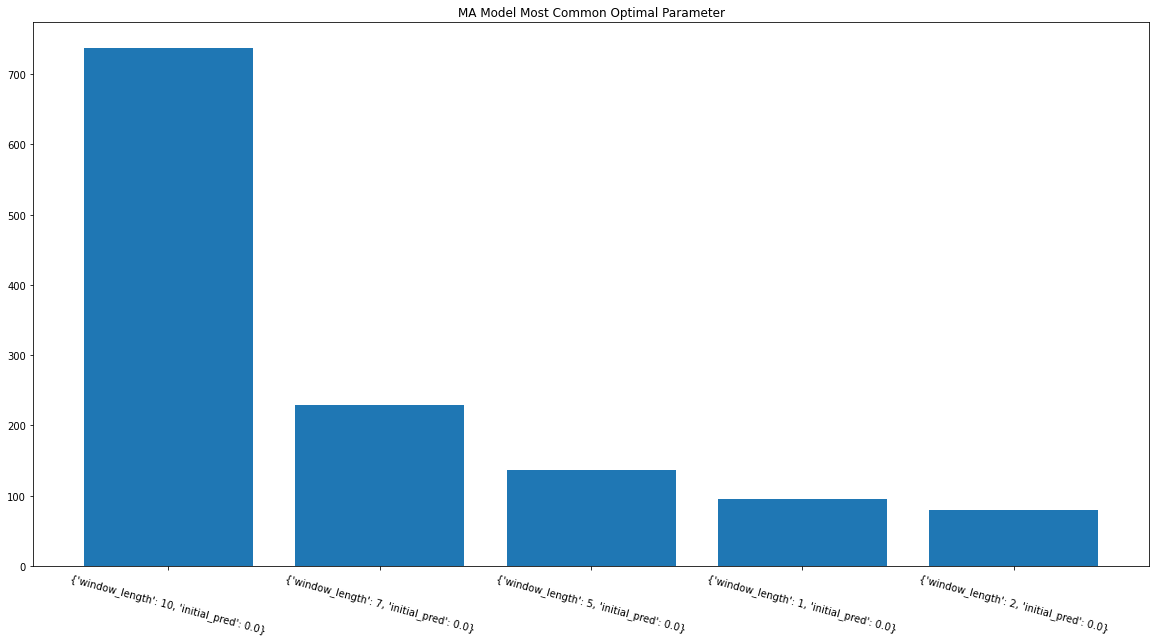

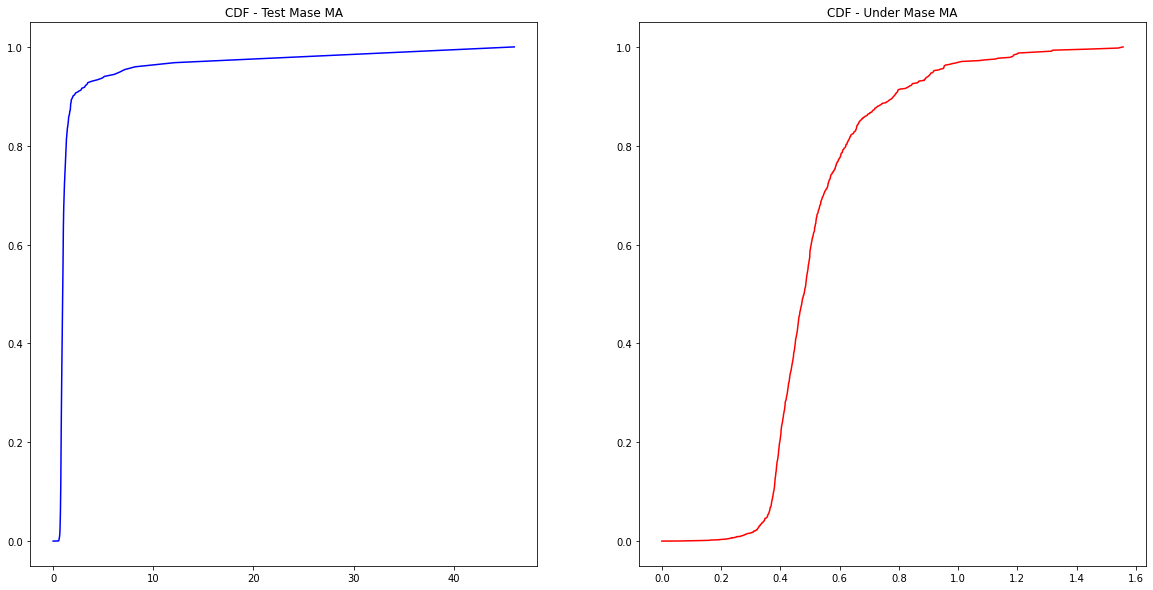

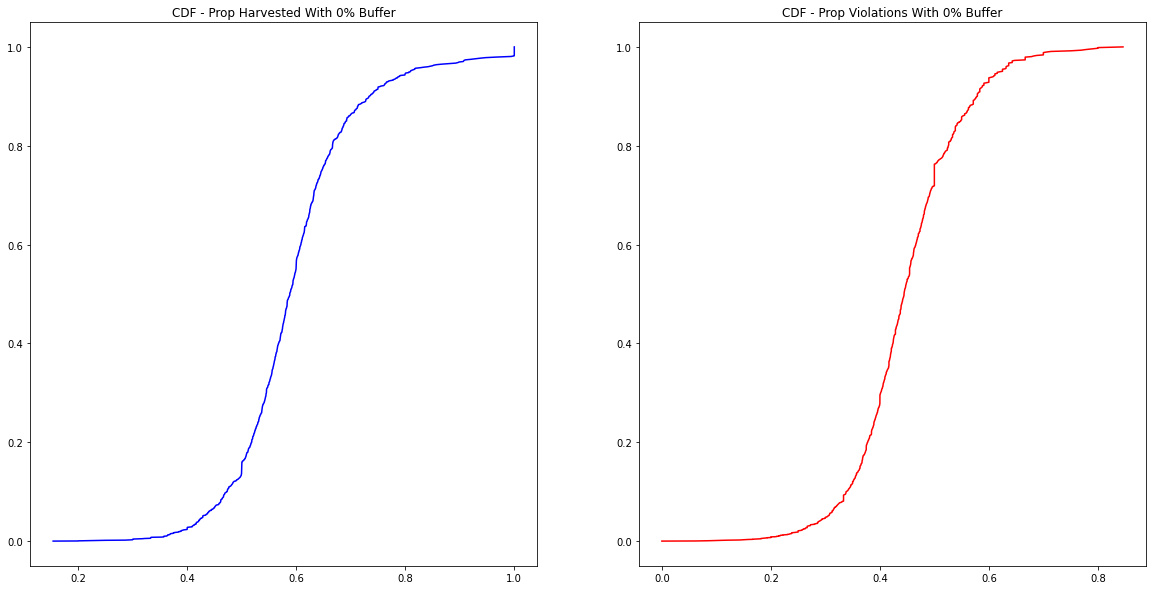

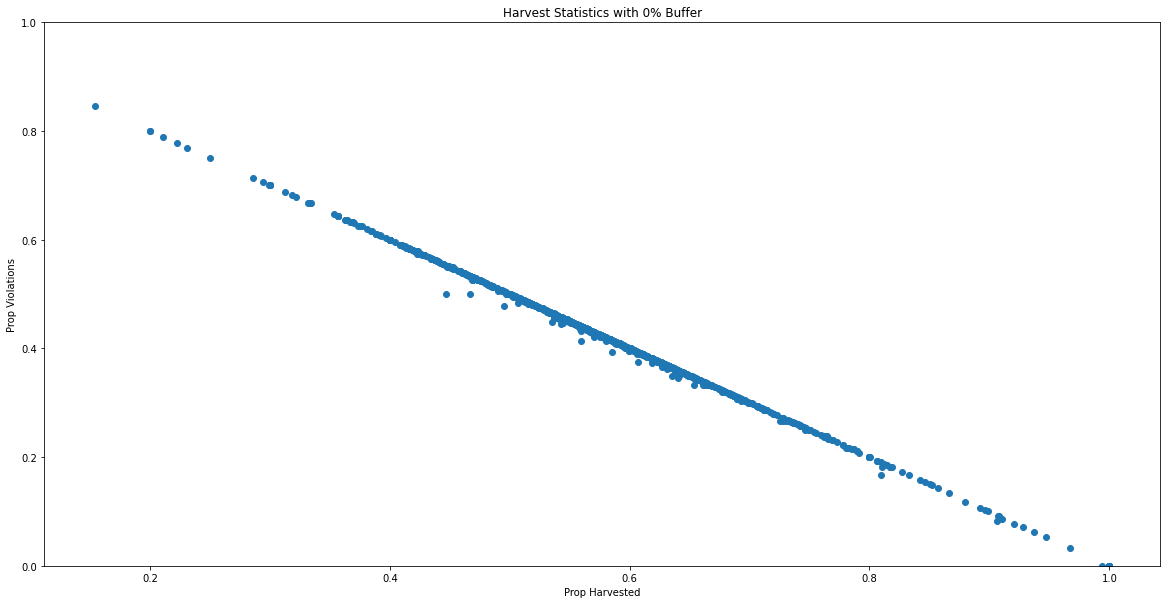

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.577709         0.421730
std          0.111606         0.111696
min          0.154025         0.000000
25%          0.516324         0.368421
50%          0.574795         0.424669
75%          0.630933         0.483379
max          1.000000         0.846154


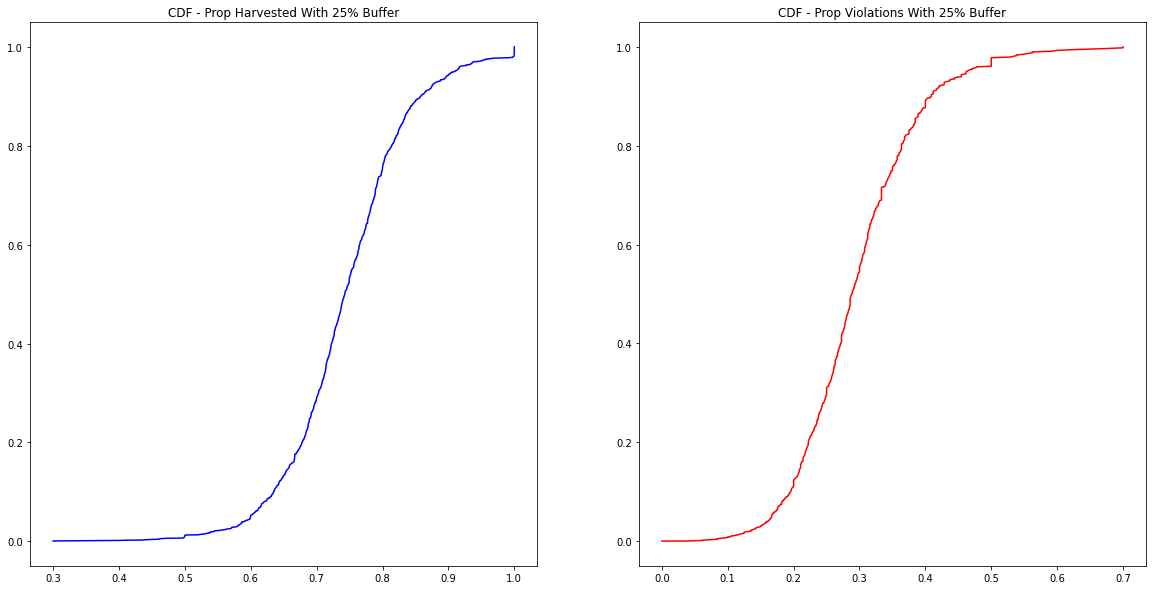

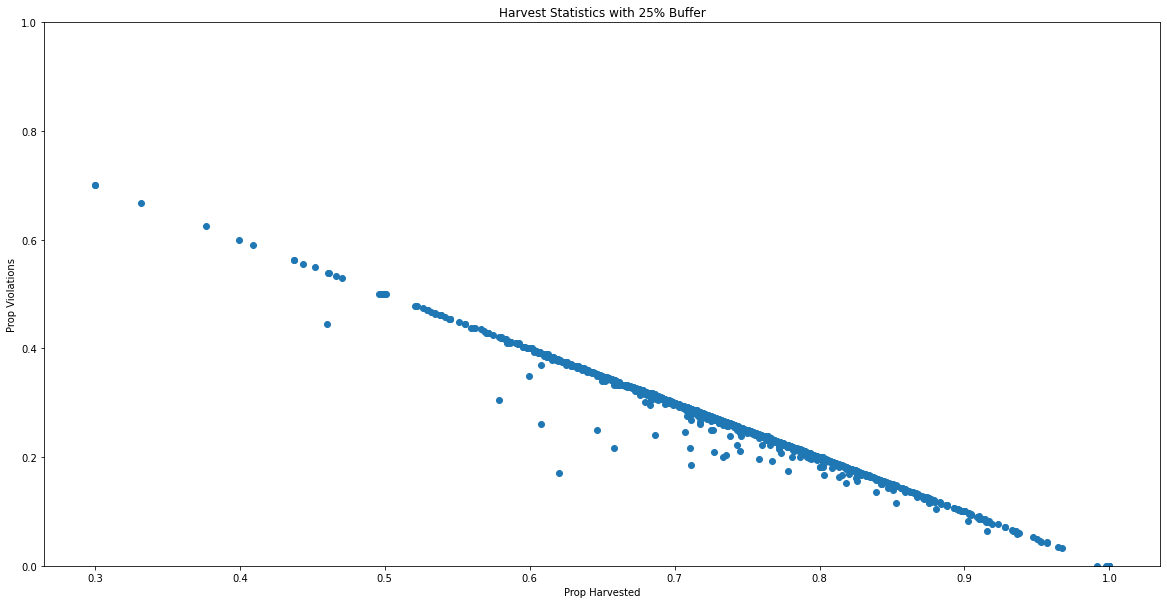

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.733728         0.263701
std          0.095391         0.095399
min          0.299937         0.000000
25%          0.681606         0.208333
50%          0.733126         0.263158
75%          0.789356         0.315789
max          1.000000         0.700000


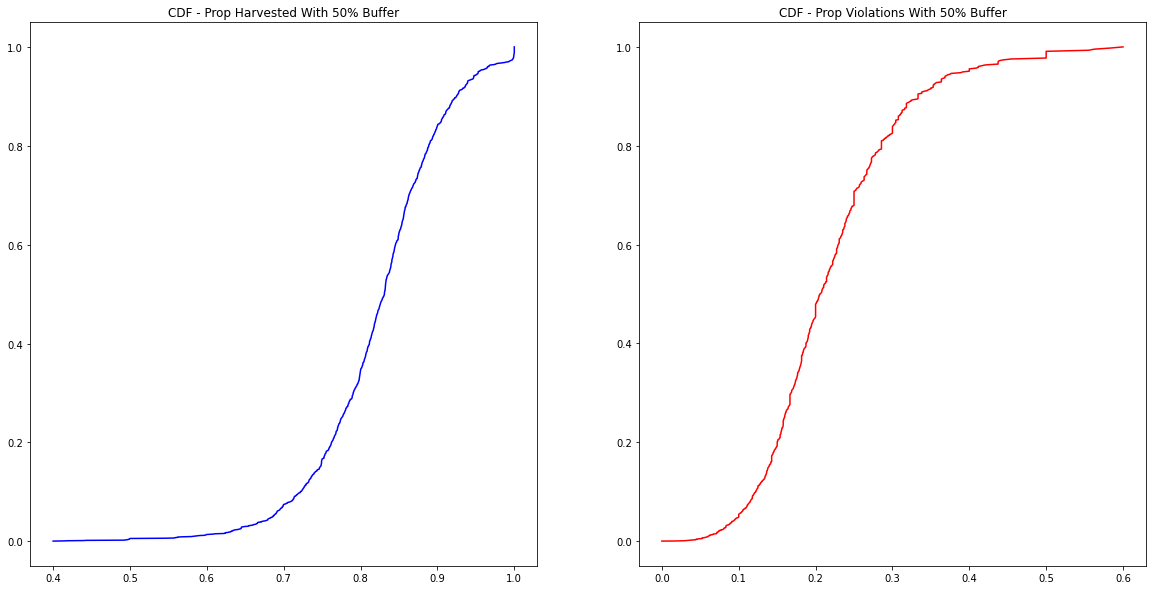

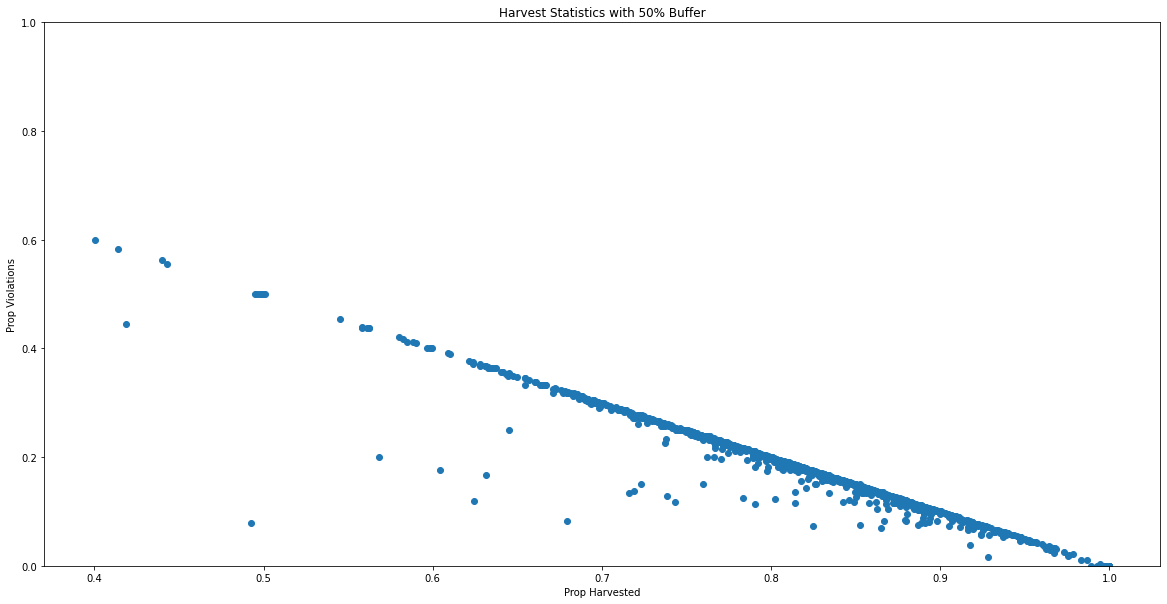

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.814884         0.180113
std          0.087651         0.086592
min          0.400236         0.000000
25%          0.767331         0.125000
50%          0.821816         0.173372
75%          0.868229         0.228571
max          1.000000         0.600000


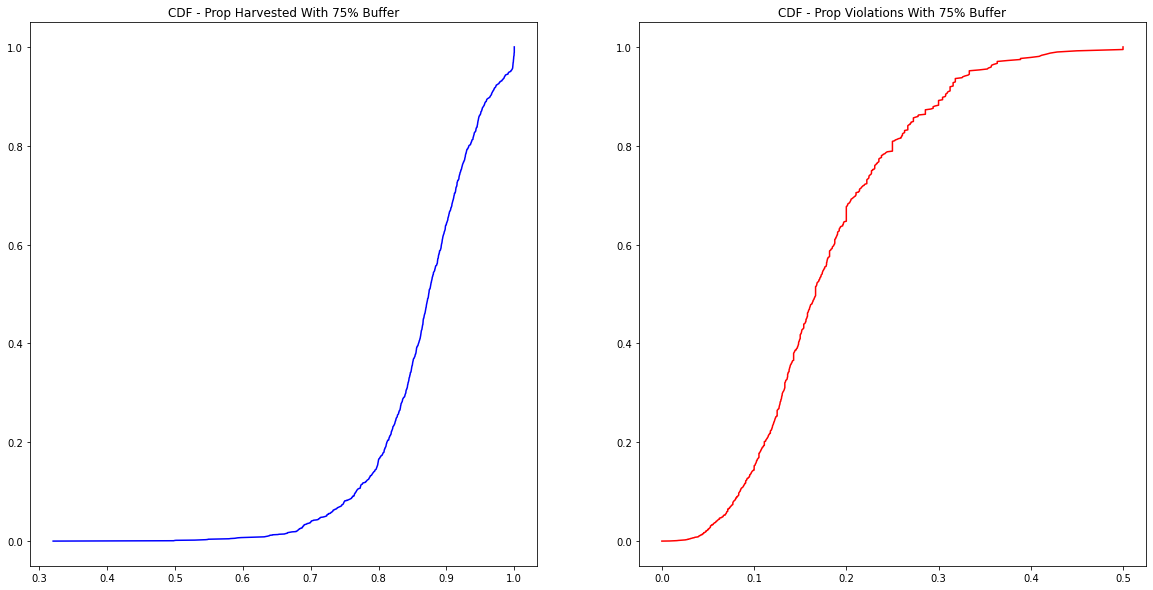

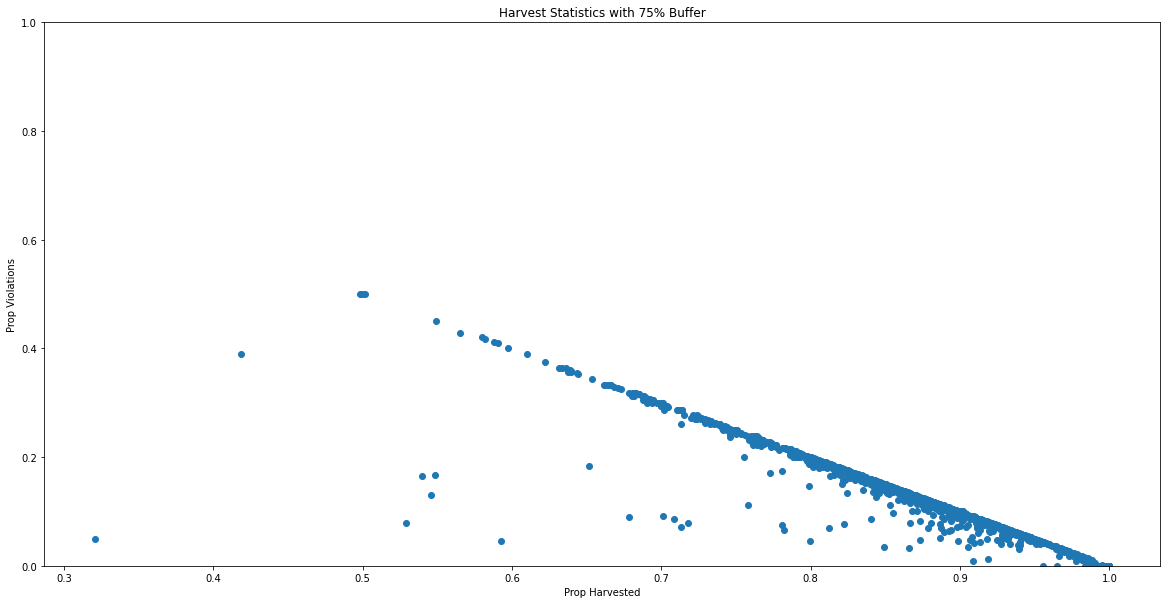

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.860030         0.132452
std          0.084696         0.080964
min          0.320687         0.000000
25%          0.818561         0.076923
50%          0.868941         0.126405
75%          0.915647         0.174793
max          1.000000         0.500000


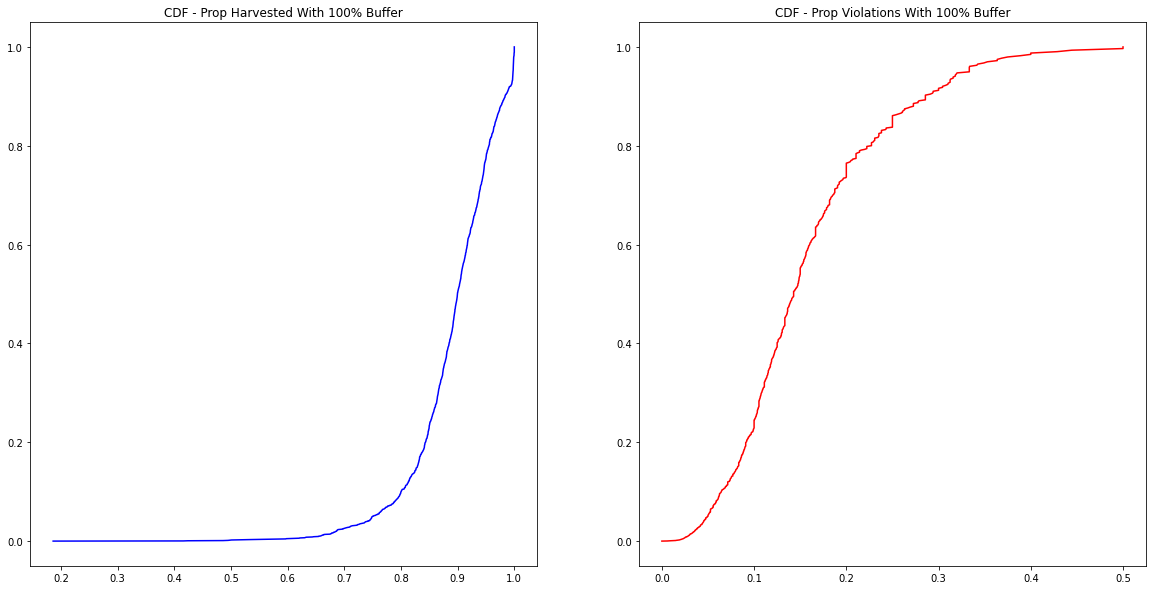

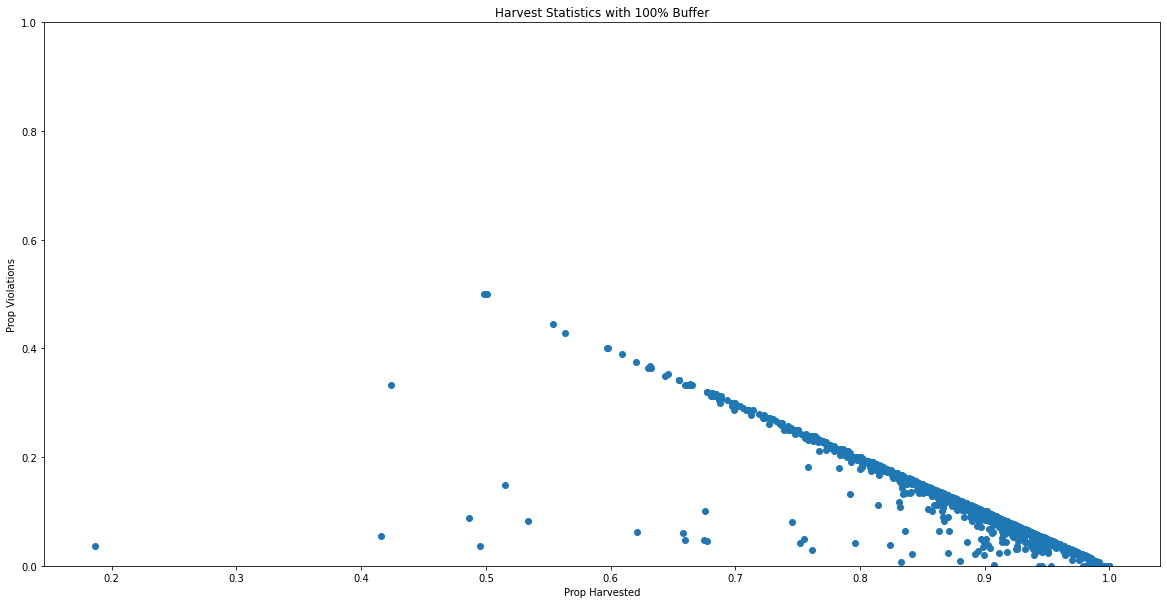

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.884914         0.105078
std          0.083534         0.076366
min          0.186399         0.000000
25%          0.847968         0.050000
50%          0.895199         0.099237
75%          0.942292         0.144097
max          1.000000         0.500000


In [19]:
model_results_dfs['ma'] = get_model_results(max_cpu_3_dir, 5, "ma")

                 id  train_mase_es  test_mase_es  under_mase_es  \
count  1.432000e+03   1.432000e+03   1432.000000    1432.000000   
mean   3.708082e+11   1.049982e+00      1.470329       0.442853   
std    7.680769e+10   4.914489e-01      4.665745       0.191451   
min    1.950000e+02   7.082153e-07      0.000000       0.000000   
25%    3.807102e+11   8.287089e-01      0.779524       0.368218   
50%    3.835432e+11   9.184830e-01      0.900996       0.425982   
75%    3.961267e+11   1.107470e+00      1.085231       0.509031   
max    4.004415e+11   8.447839e+00     98.512736       1.585270   

       prop_under_preds_es  max_under_pred_es  over_mase_es  \
count          1432.000000        1375.000000   1432.000000   
mean              0.362373          39.836236      1.027476   
std               0.145080         196.429000      4.705345   
min               0.000000           0.006722      0.000000   
25%               0.283733           2.470248      0.376758   
50%               

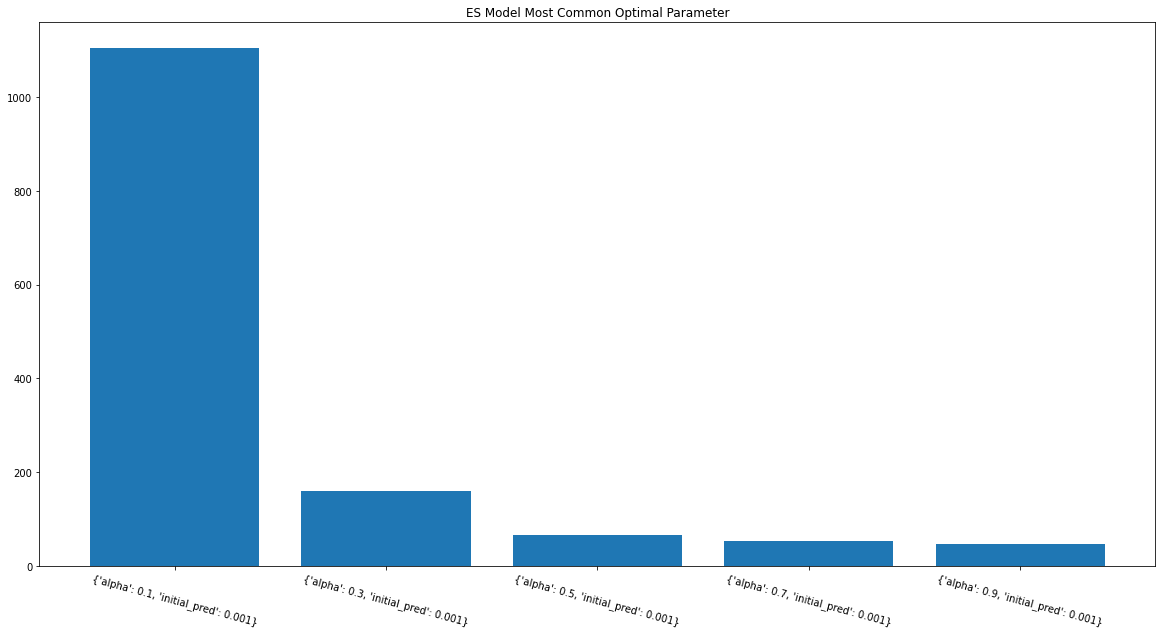

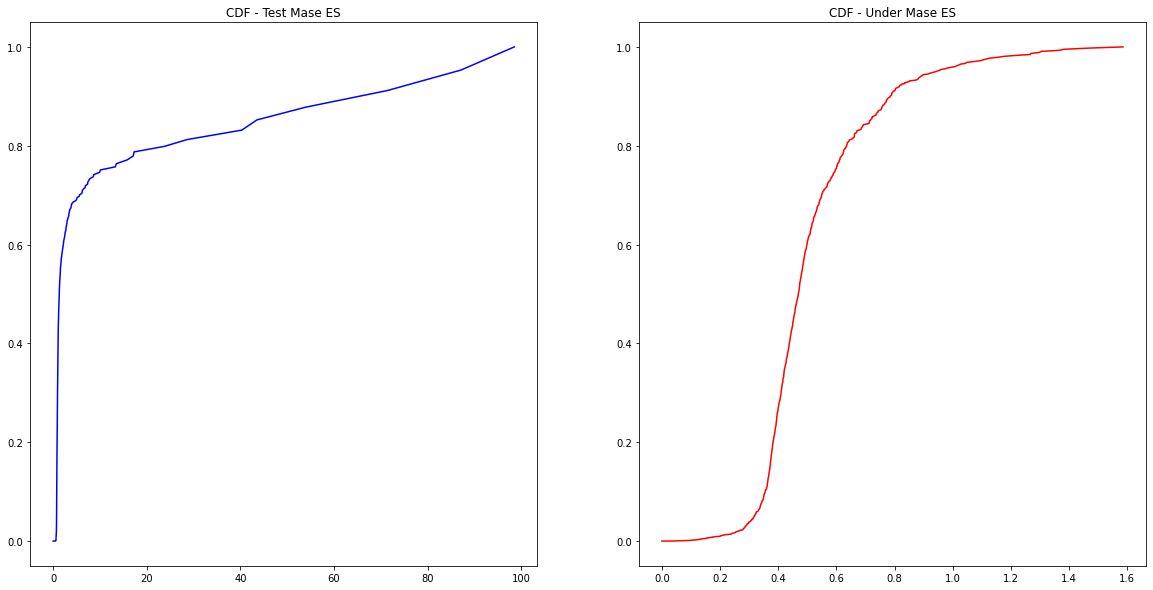

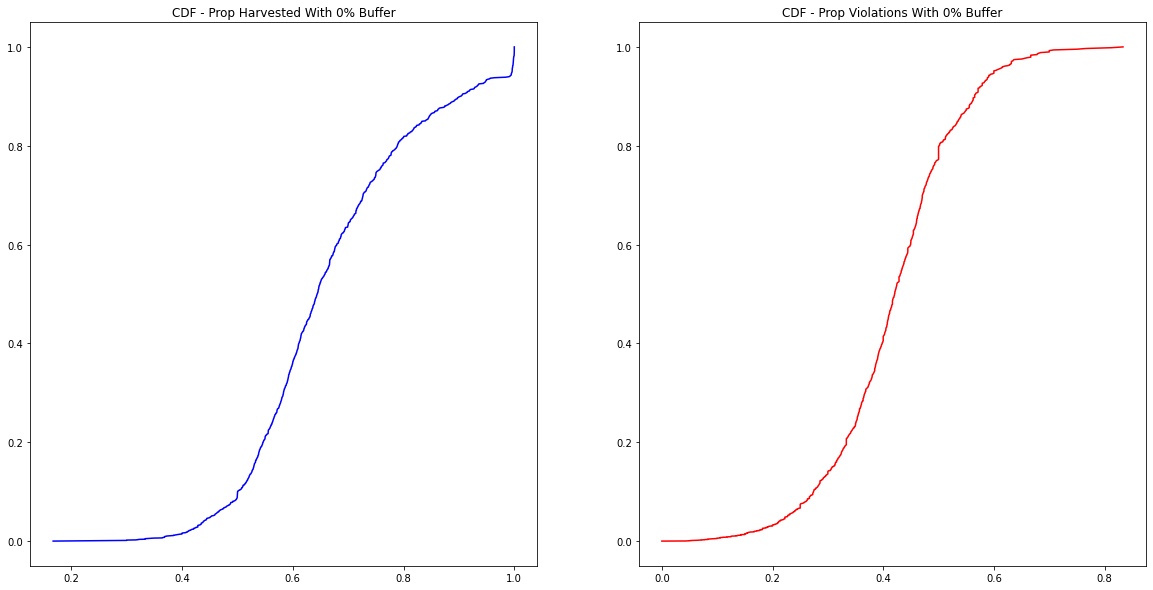

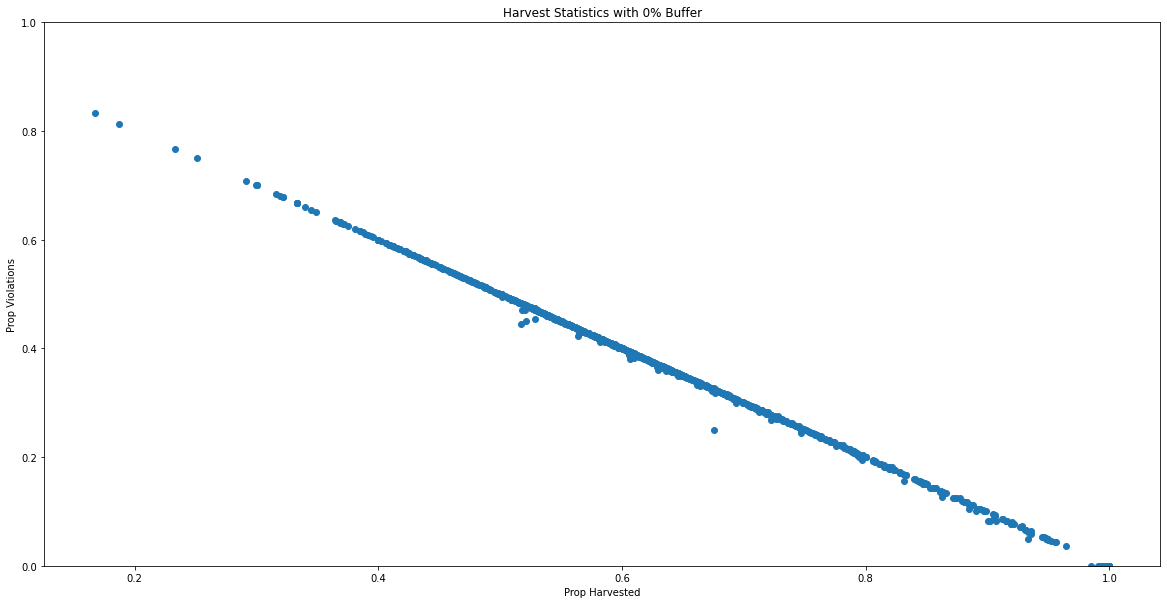

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.637020         0.362373
std          0.144564         0.145080
min          0.167350         0.000000
25%          0.540907         0.283733
50%          0.614625         0.384615
75%          0.715547         0.458333
max          1.000000         0.833333


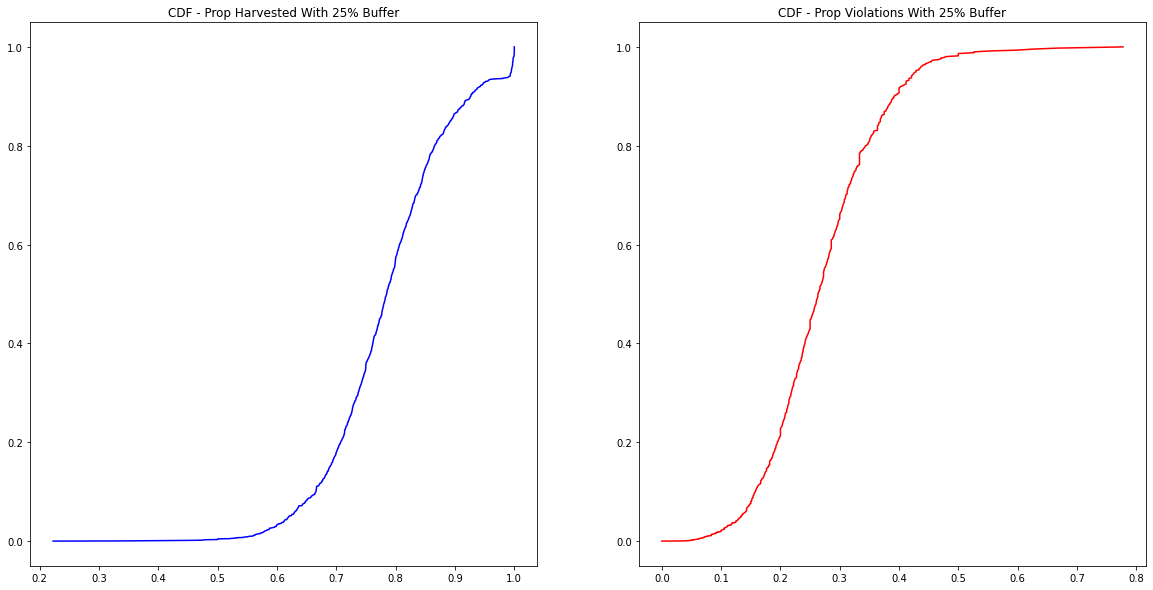

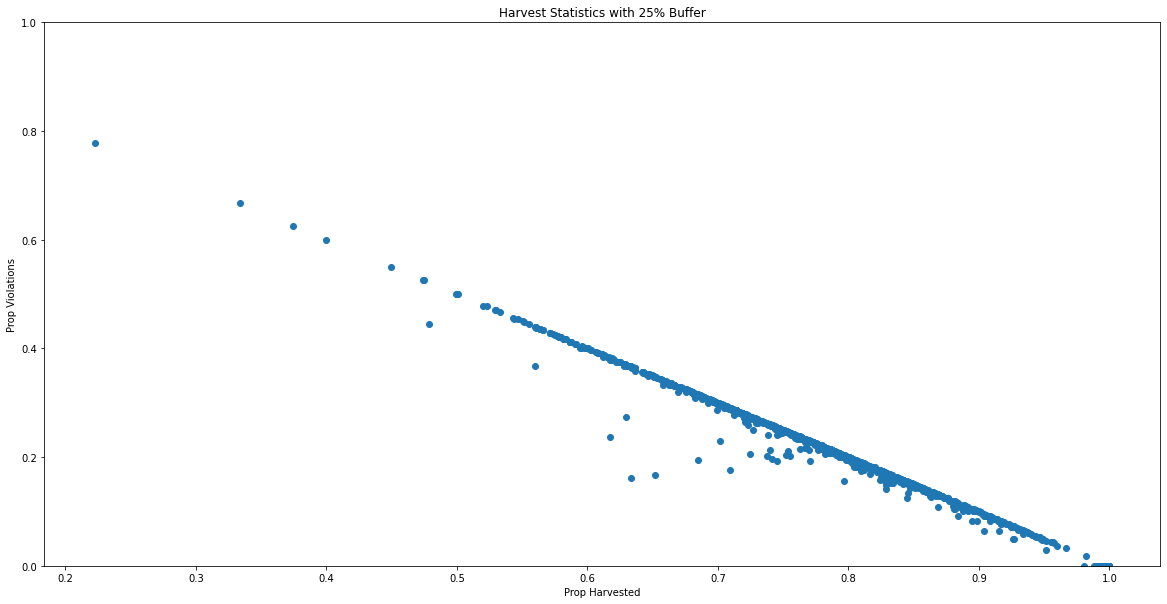

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.774080         0.223098
std          0.103809         0.104056
min          0.222529         0.000000
25%          0.710965         0.158700
50%          0.772814         0.222222
75%          0.838365         0.285714
max          1.000000         0.777778


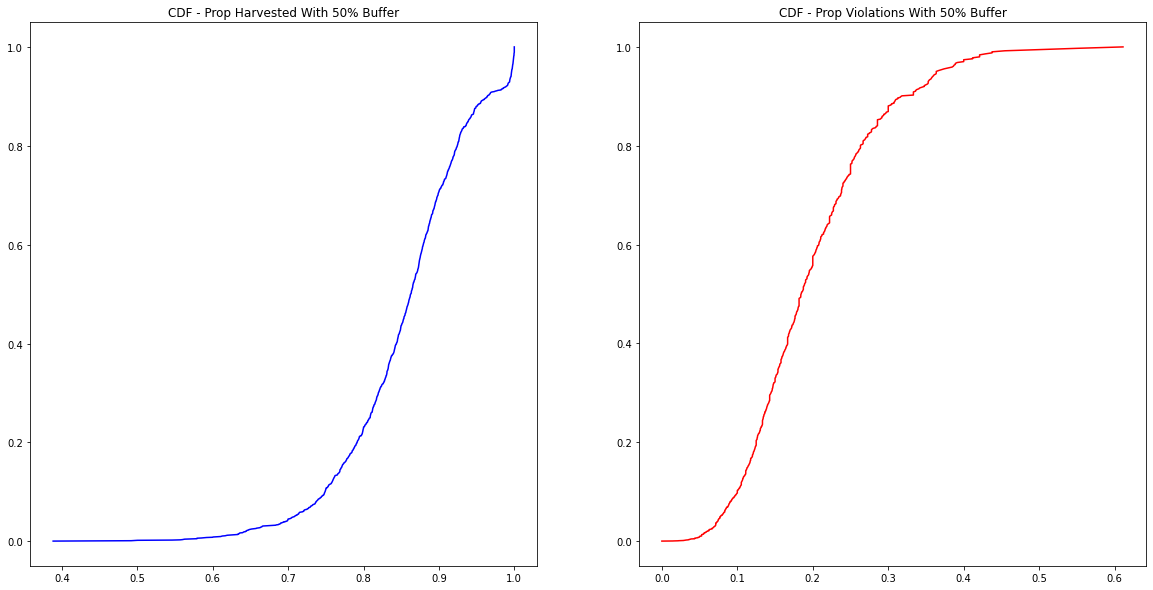

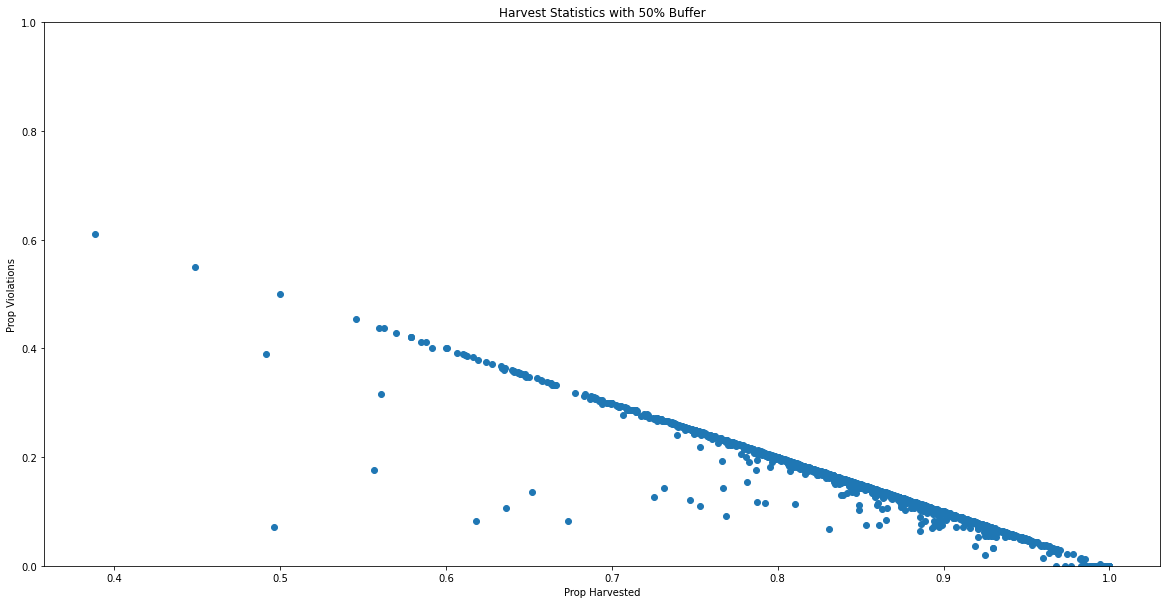

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.846458         0.148116
std          0.088907         0.087593
min          0.388152         0.000000
25%          0.797708         0.089744
50%          0.855231         0.139876
75%          0.903941         0.199306
max          1.000000         0.611111


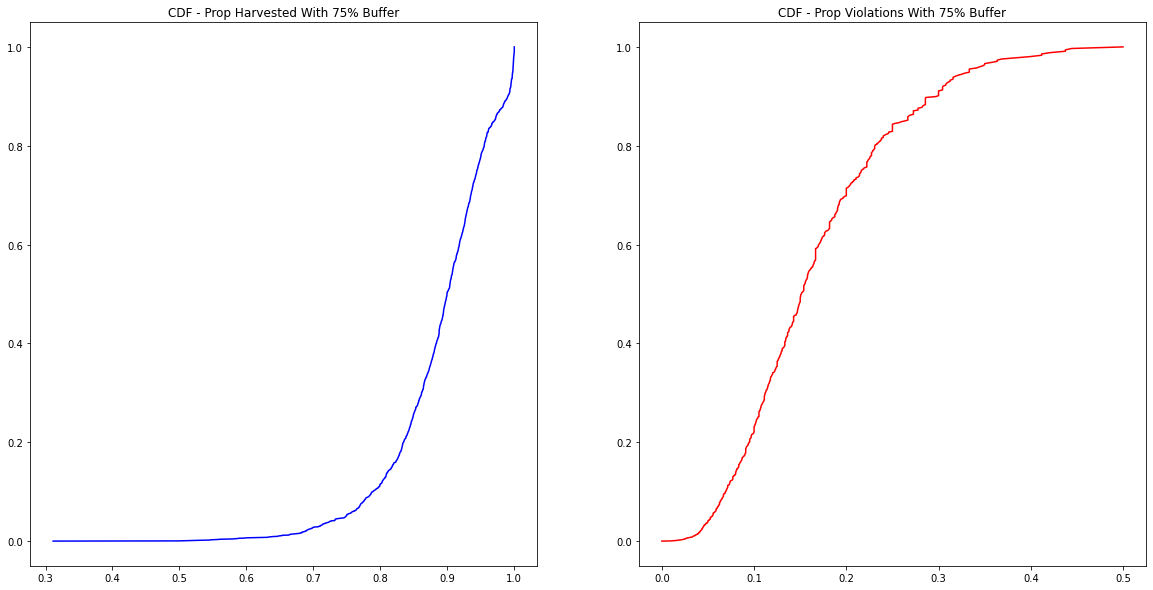

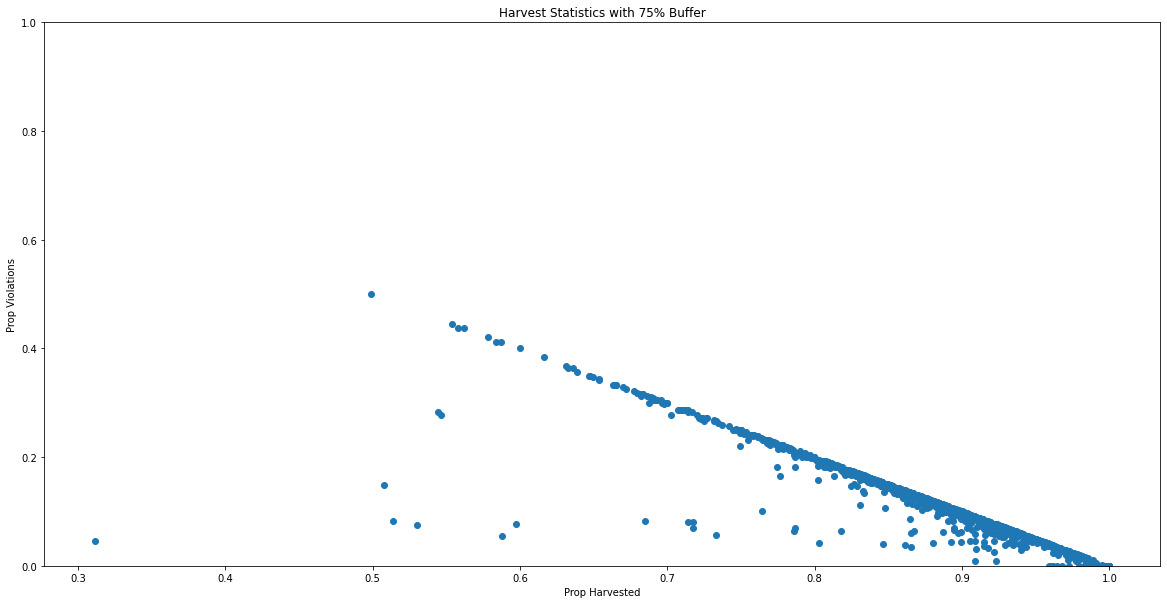

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.882158         0.109784
std          0.084339         0.079807
min          0.311388         0.000000
25%          0.840934         0.053967
50%          0.894389         0.100000
75%          0.938988         0.152668
max          1.000000         0.500000


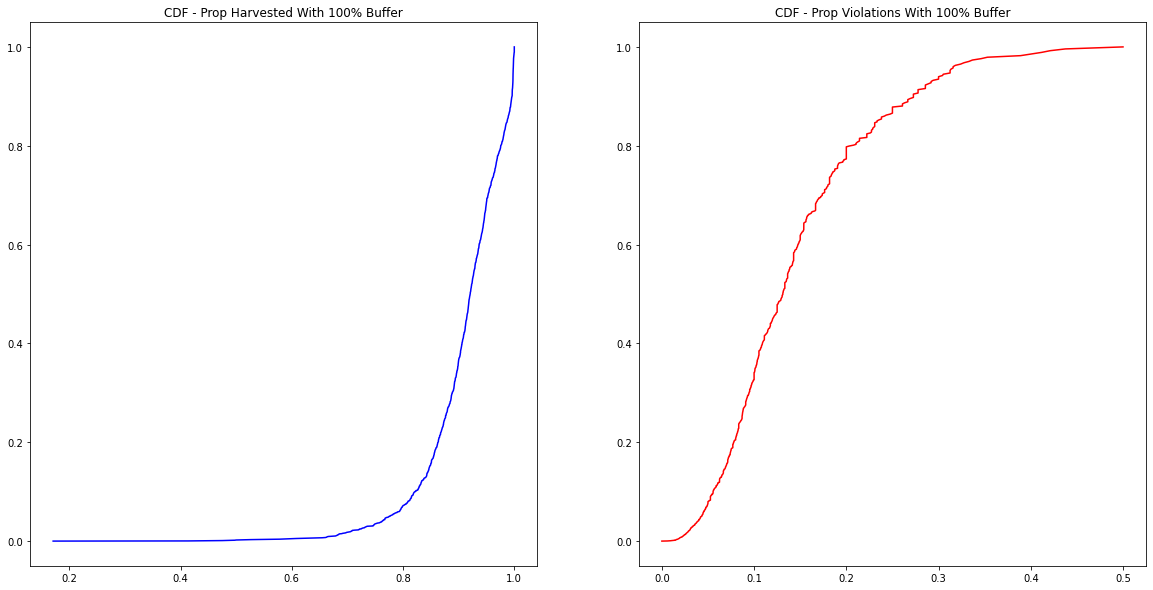

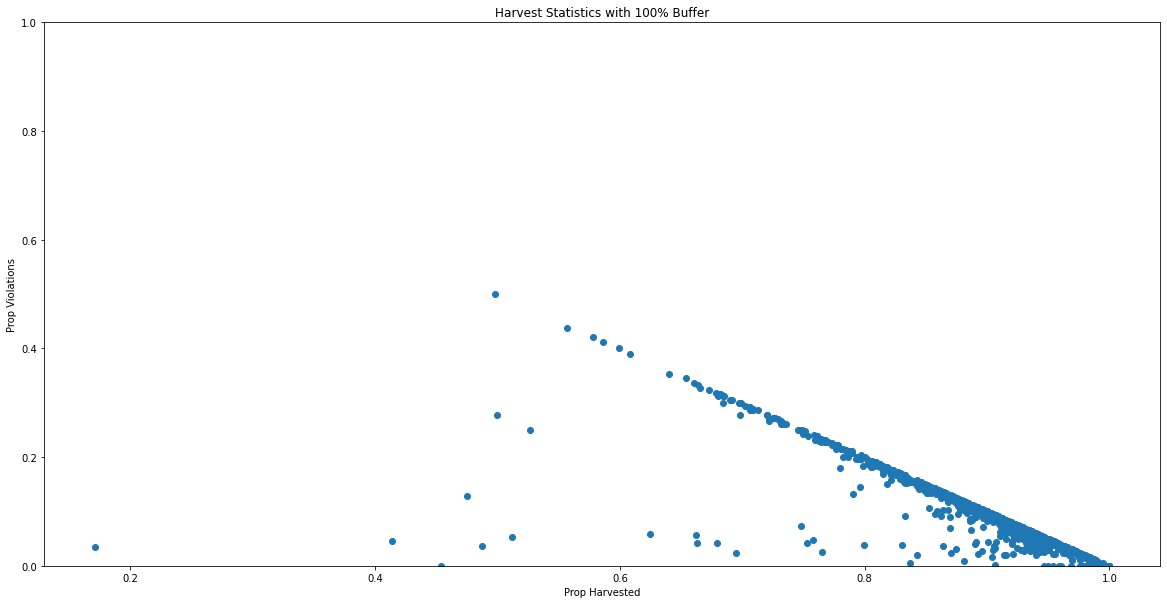

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.903704         0.085598
std          0.081721         0.072669
min          0.171011         0.000000
25%          0.868439         0.030969
50%          0.916870         0.074480
75%          0.958855         0.123955
max          1.000000         0.500000


In [20]:
model_results_dfs['es'] = get_model_results(max_cpu_3_dir, 5, "es")

                 id  train_mase_ar  test_mase_ar  under_mase_ar  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       0.869414      1.579622       1.064597   
std    7.680769e+10       0.208855      3.745821       0.644393   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.794786      0.904430       0.642924   
50%    3.835432e+11       0.844796      1.191897       0.949826   
75%    3.961267e+11       0.918850      1.769950       1.350437   
max    4.004415e+11       4.813378    136.539925       4.917170   

       prop_under_preds_ar  max_under_pred_ar  over_mase_ar  \
count          1432.000000       1.406000e+03   1432.000000   
mean              0.666314       7.710672e+03      0.515025   
std               0.275776       1.000785e+05      3.782997   
min               0.000000       1.426298e-02      0.000000   
25%               0.500000       4.513136e+00      0.015405   
50%               

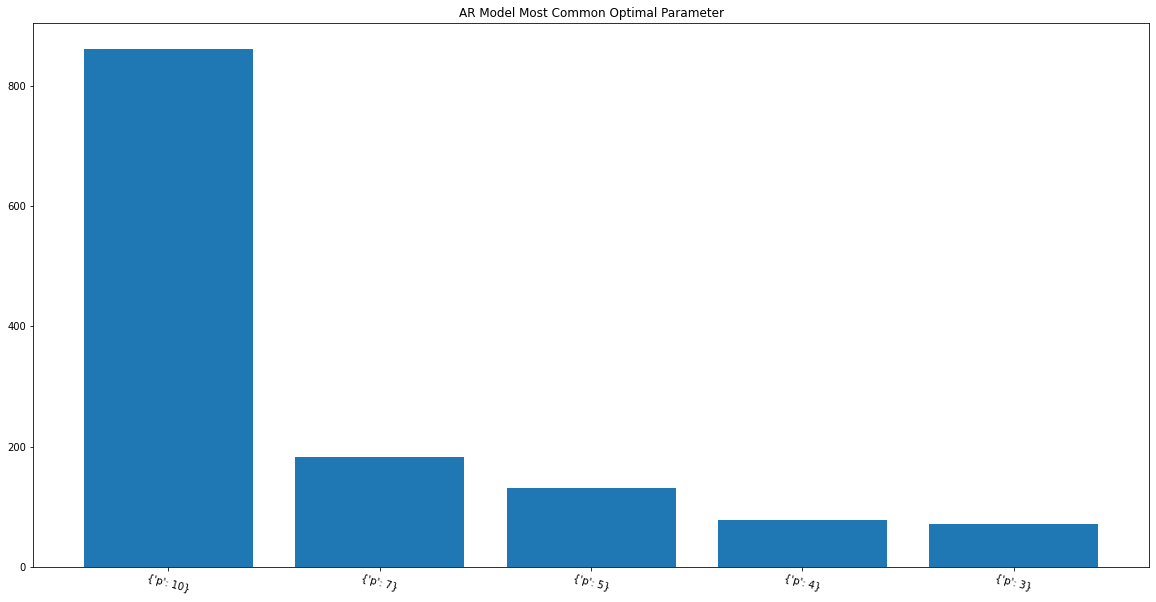

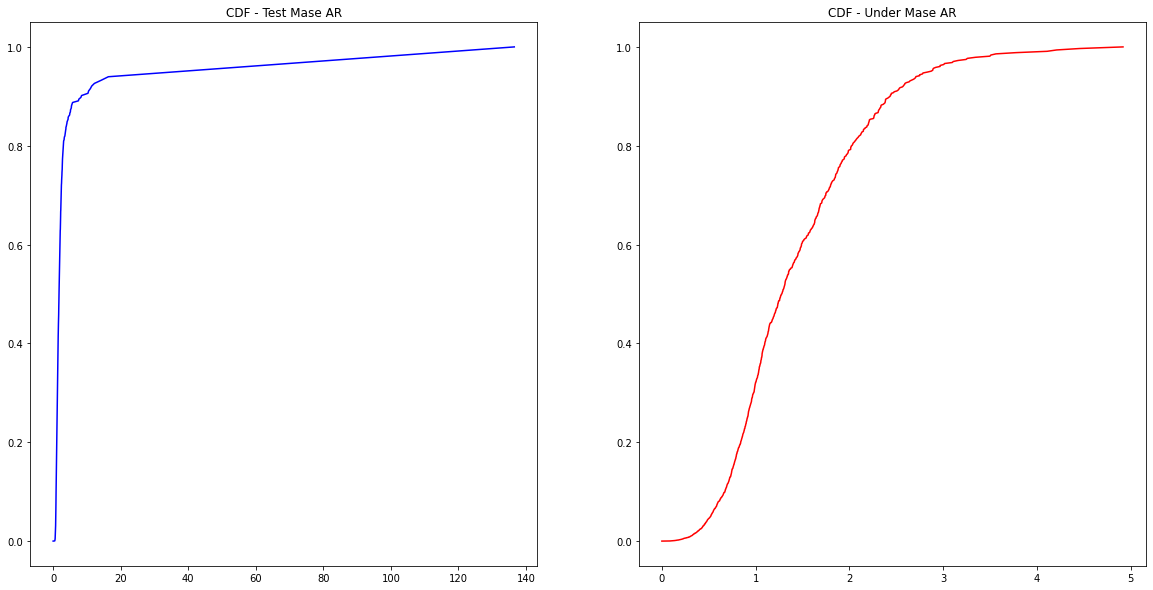

In [ ]:
model_results_dfs['ar'] = get_model_results(max_cpu_3_dir, 5, "ar")

In [ ]:
model_results_dfs['reg'] = get_model_results(max_cpu_3_dir, 5, "reg")

In [ ]:
model_results_dfs['svm'] = get_model_results(max_cpu_3_dir, 5, "svm")

In [ ]:
model_results_dfs['xgb'] = get_model_results(max_cpu_3_dir, 5, "xgb")

In [ ]:
model_results_dfs['arima'] = get_model_results(max_cpu_3_dir, 5, "arima")

In [ ]:
plot_all_cdfs_across_models(model_results_dfs)

In [ ]:
compare_model_harvest_results(model_results_dfs)

In [ ]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_cpu_3_dir)

In [ ]:
model_names = list(model_results_dfs.keys()) + ['best']

In [ ]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_cpu_3_dir)

In [ ]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

In [ ]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

In [ ]:
print("Proportion of CPU Harvested with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

In [ ]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")